In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

In [2]:
path="./data/"
file='Cor_train.pkl'
train_df= pd.read_pickle(path+file)
file1='Cor_test.pkl'
test_df= pd.read_pickle(path+file1)

In [3]:
X_train=train_df.drop(train_df.columns[0:3], axis=1)
y_train=train_df["TC"]
X_test=test_df.drop(test_df.columns[0:3], axis=1)
y_test=test_df["TC"]

select_feature=[
'Monomer_length',
 'MW_ratio',
 'Mass_max',
 'Mass_ave',
 'K_bond_ave',
 'K_ang_ave',
 'nH',
 'AATS0d',
 'AATS0Z',
 'ATSC2Z',
 'ATSC5Z',
 'AATSC0Z',
 'AATSC2Z',
 'BCUTd-1h',
 'BCUTZ-1h',
 'nHBDon',
 'MIC0',
 'MIC1',
 'Kier3',
 'Mor02',
 'Mor14',
 'Mor19',
 'SMR_VSA1',
 'SMR_VSA3',
 'VSA_EState4']

X_selecttrain=X_train[select_feature]
X_selecttest=X_test[select_feature]
for i in [X_selecttrain,X_selecttest, y_train, y_test]:
    i.index = range(i.shape[0])
scaler.fit(X_selecttrain)
#scaler.fit(Xtest)
Xtrain  = scaler.transform(X_selecttrain)
Xtest = scaler.transform(X_selecttest)

In [6]:
#RF model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import math

n_estimator = int(1243.5126904380131)
max_depths = int(19.278129232569064)
min_samples_split=int(np.round(5.816558946743761))
min_samples_leaf=int(np.round(2.989362159767528))
rfg = RandomForestRegressor(n_estimators = n_estimator, max_features='auto',random_state=1, max_depth = max_depths,min_samples_split=min_samples_split,min_samples_leaf=min_samples_leaf)
rfg.fit(Xtrain,y_train.values.ravel())
res = rfg.predict(Xtest)
print("Training set score: %f" % rfg.score(Xtrain,y_train))
print("Test set score: %f" % rfg.score(Xtest,y_test))
mse=mean_squared_error(y_test,res)
rmse=math.sqrt(mse)
print('MSE:{}'.format(mse))
print('RMSE:{}'.format(rmse))
RF_train= rfg.predict(Xtrain)
RF_test= rfg.predict(Xtest)

Training set score: 0.882925
Test set score: 0.777199
MSE:0.0008715691895641649
RMSE:0.029522350678158487


In [8]:
#SHAP Analysis
import shap
import matplotlib.pyplot as plt
shap.initjs()

In [11]:
feature_name_list =X_selecttrain.columns.values.tolist() 
X_FEATURE = pd.DataFrame(Xtrain,columns=feature_name_list)
explainer = shap.TreeExplainer(rfg)
shap_values = explainer.shap_values(Xtrain)

           Labels    Values
0  Monomer_length  0.003483
1        Mass_max  0.003580
2          AATS0Z  0.003737
3        BCUTd-1h  0.004491
4      K_bond_ave  0.005194
5        MW_ratio  0.005398
6          AATS0d  0.006465
7        BCUTZ-1h  0.022127


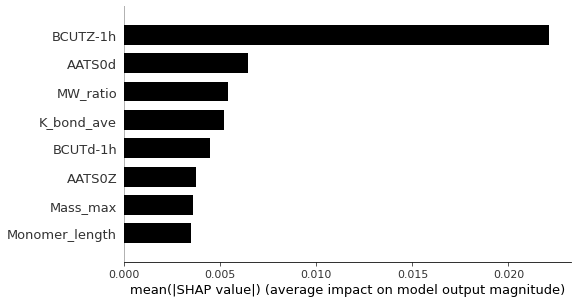

In [12]:
ax =shap.summary_plot(shap_values, X_FEATURE , plot_type="bar", title='Train', max_display=8, show=False, color="k")
ax = plt.gca()
labels = [l.get_text() for l in ax.get_yticklabels()]
values = [rect.get_width() for rect in ax.patches]
df_feature = pd.DataFrame({'Labels': labels, 'Values': values})

print(df_feature)

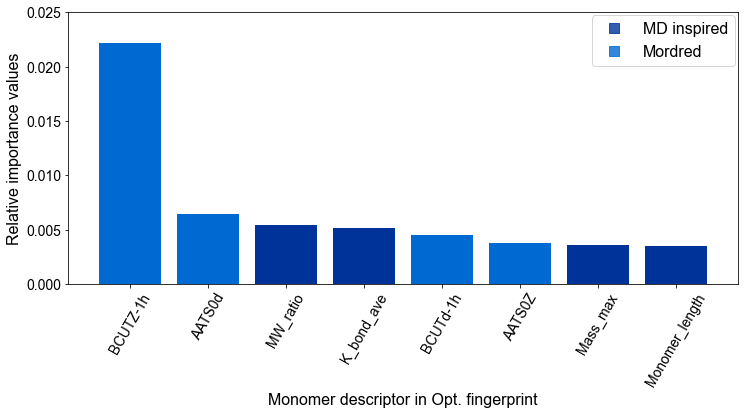

In [21]:
from matplotlib.lines import Line2D
plt.figure(figsize=(12,5))
plt.rc('font',family='Arial',weight='normal')
font1 = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 16,
}
pyhiscalfeature=['Monomer_length', 'MW_ratio','Mass_max','Mass_ave','K_bond_ave','K_ang_ave',]
#plt.title('COE Feature importances')
colorbar=['#003399','#0069D2']
colorlist=[]
for feature in df_feature["Labels"]:
    if feature in pyhiscalfeature:
        colorlist.append(colorbar[0])
    else:
        colorlist.append(colorbar[1])
plt.bar(range(len(df_feature)),df_feature["Values"][::-1],color=colorlist[::-1],  align='center')  
plt.xticks(range(len(df_feature)),df_feature["Labels"][::-1], rotation=60,fontsize=14)
plt.yticks([0.000, 0.005, 0.010, 0.015, 0.020,0.025], fontsize=14)
plt.ylabel('Relative importance values', font1)
plt.xlabel('Monomer descriptor in Opt. fingerprint',font1)
descriptor_name=["MD inspired","Mordred"]
label=[1,2]
legend_elements = []
legend_font = {'family' : 'Arial', 'weight' : 'normal', 'size': 16}
for label, name in enumerate(descriptor_name):
    legend_elements.append(Line2D(
        [0], [0], marker='s', lw=0, markersize=10,
        color=colorbar[label], label=name, alpha=0.8))
    #ax.legend(prop=legend_font,bbox_to_anchor=(1, 1), loc=1, borderaxespad=0.2,handles=legend_elements)
    plt.legend(prop=legend_font,loc="best",borderaxespad=0.2,handles=legend_elements)
plt.show()

In [27]:
feature1=df_feature["Labels"][::-1]
SHAP=pd.DataFrame(shap_values,columns=feature_name_list)
SHAP_rank=SHAP[feature1]
X_FEATURE_rank=X_FEATURE[feature1]
X_FEATURE

,Monomer_length,MW_ratio,Mass_max,Mass_ave,K_bond_ave,K_ang_ave,nH,AATS0d,AATS0Z,ATSC2Z,...,nHBDon,MIC0,MIC1,Kier3,Mor02,Mor14,Mor19,SMR_VSA1,SMR_VSA3,VSA_EState4
0,0.807113,0.942242,1.164592,0.243234,-0.060297,-0.258654,0.336458,-0.090892,0.525206,-0.470727,...,-0.359397,0.946855,1.147481,0.515740,-0.254675,0.075050,0.689388,0.142893,-0.542235,0.340780
1,0.638687,0.572639,-0.292470,-0.466223,0.116468,-0.396454,1.125637,-0.030524,-0.409294,1.634696,...,-0.359397,-0.697195,-0.133958,-0.042589,0.879263,-0.169835,0.660302,-0.141168,-0.542235,1.567229
2,-0.859253,-1.175727,-0.292470,-0.958098,-0.790237,-0.932772,0.336458,-0.947467,-0.730890,-0.827133,...,-0.359397,-0.934959,-0.579838,-0.195753,-0.384172,1.086169,0.427701,-0.727775,-0.542235,0.485517
3,-0.044491,0.245868,-0.473107,-0.357690,0.485861,-0.196812,0.040516,-0.000340,-0.426825,-1.175149,...,-0.359397,-1.089516,-1.049007,-0.180206,-0.579029,-0.226198,-0.241906,-1.008419,-0.542235,1.176452
4,-0.860305,-1.175637,-0.292470,-0.611837,-0.226698,-0.604116,-0.058132,-0.575666,-0.516193,0.154156,...,-0.359397,-0.568821,0.008762,-0.315210,0.037788,0.127821,0.136420,-0.443714,-0.542235,0.222111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.908169,1.135747,-0.292470,0.579250,1.237955,0.780392,0.139163,1.165155,0.233106,-0.369177,...,-0.359397,0.061076,0.360574,0.116445,0.433593,-0.495809,-1.599542,0.689113,0.723745,0.500846
836,0.849220,-0.109908,1.164592,1.174220,0.199102,1.324866,0.533753,1.132358,0.987594,3.374360,...,2.690032,1.880785,1.837614,0.790566,0.531471,-1.293648,-1.083433,3.800005,-0.542235,-5.209221
837,0.451313,1.135747,-0.292470,0.417475,1.483591,0.693168,-0.354074,0.603342,0.135494,-0.698936,...,2.690032,0.564150,0.681206,-0.282130,-0.201632,-0.621273,-0.324022,0.127825,1.989725,0.115682
838,1.207125,1.135747,-0.292470,0.470213,1.008416,0.516606,0.533753,1.310807,0.146799,-0.578650,...,-0.359397,-0.247708,0.179952,-0.074545,0.467550,-1.085246,-1.004401,0.411886,-0.542235,1.911380


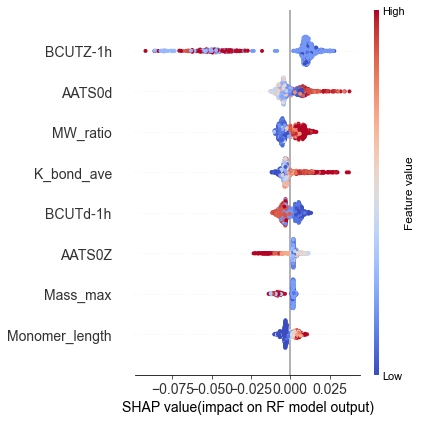

In [28]:
import matplotlib.cm as cm
ax=shap.summary_plot(np.array(SHAP_rank),X_FEATURE_rank,max_display = 8, show=False, cmap=cm.coolwarm, plot_size=(6,6),sort=False)
font1 = {'family' : 'Arial',
'weight' : 'normal',
'size'   : 14,
}
#cb=plt.colorbar(ax)
#cb.ax.tick_params(labelsize=14,length=10)
plt.rc('font', family='Arial')
plt.rcParams.update({'font.size':14})
#shap.summary_plot(shap_values,X_FEATURE,max_display = 50, show=False, cmap='copper', plot_size=(6,6),sort=False)
plt.tight_layout()
plt.xticks(fontproperties ='Arial', fontsize=14)
plt.yticks(fontproperties ='Arial', fontsize=14,rotation=0)
plt.xlabel('SHAP value(impact on RF model output)',font1)
plt.show()

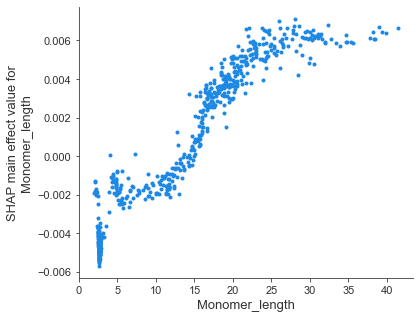

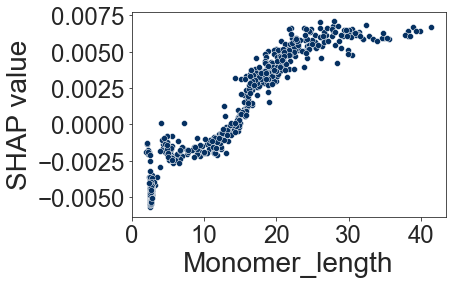

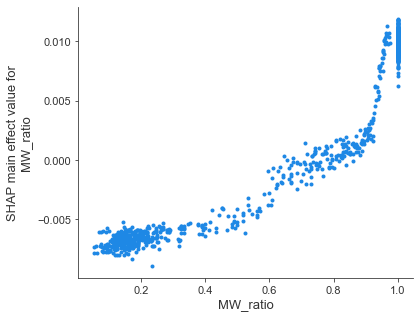

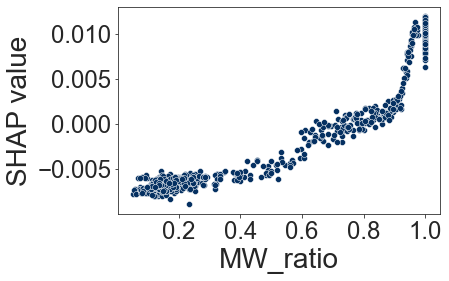

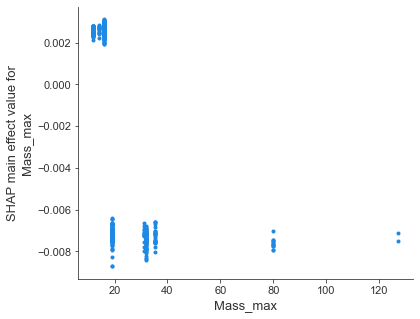

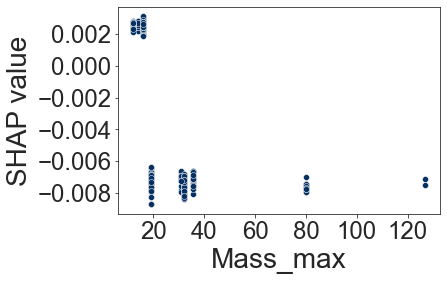

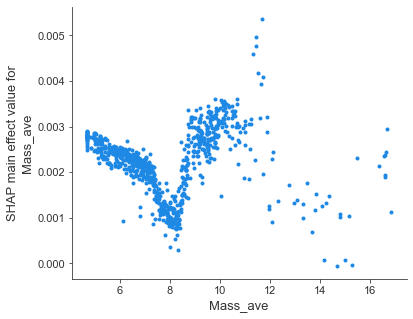

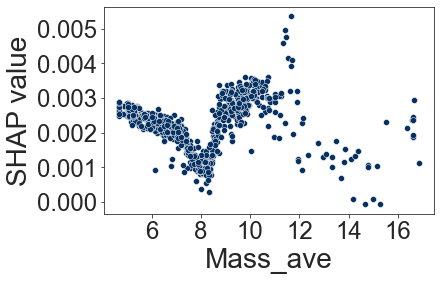

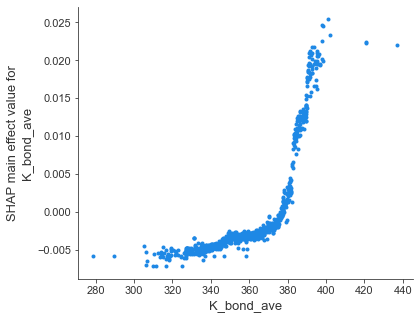

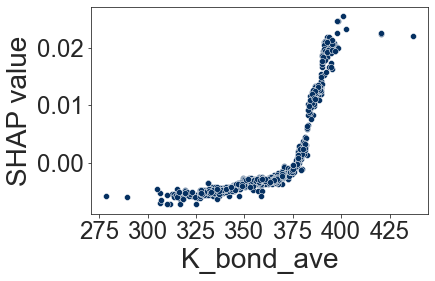

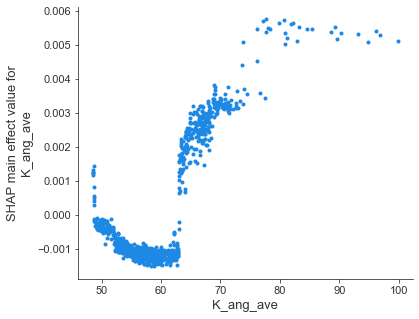

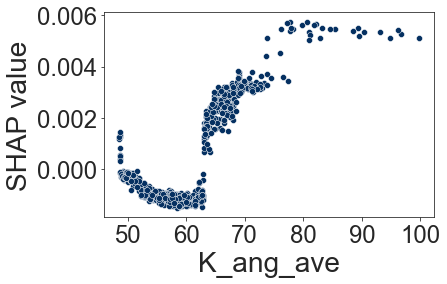

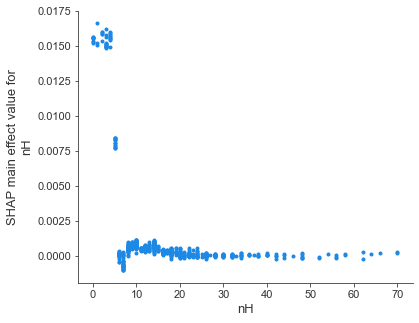

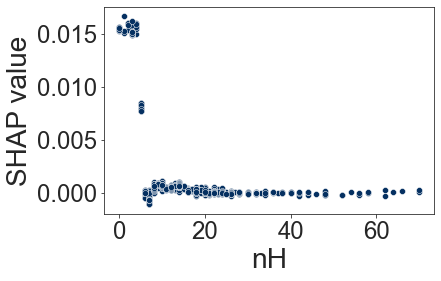

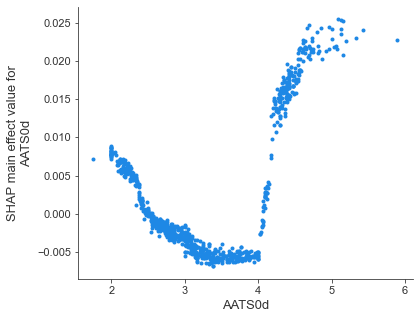

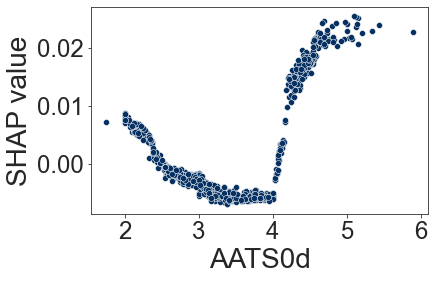

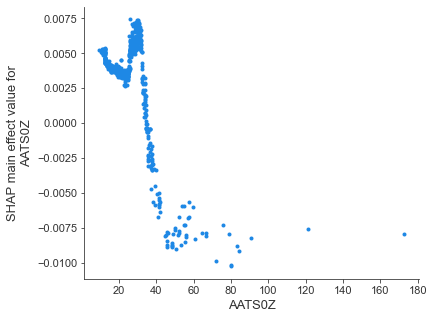

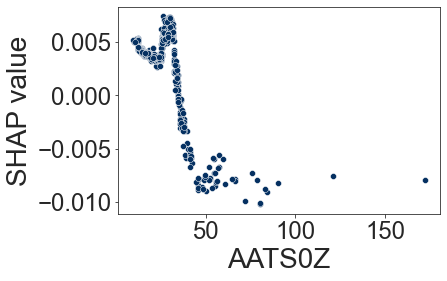

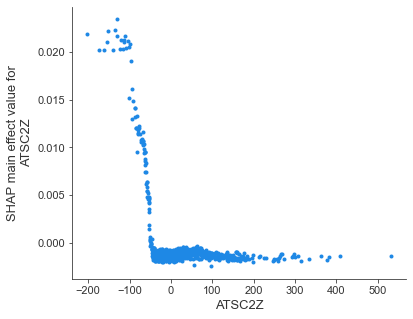

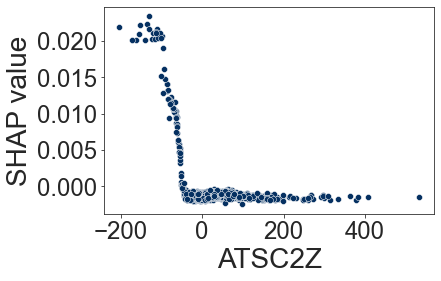

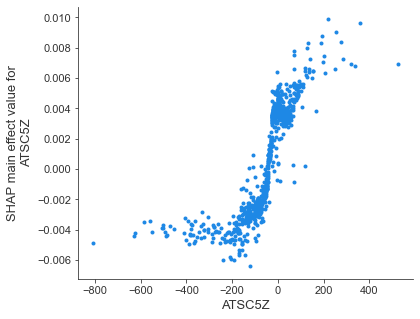

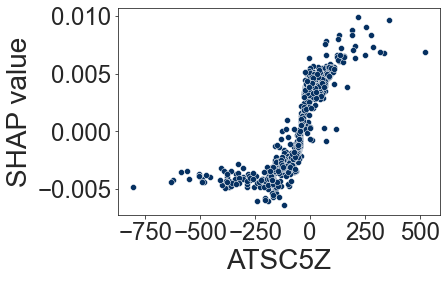

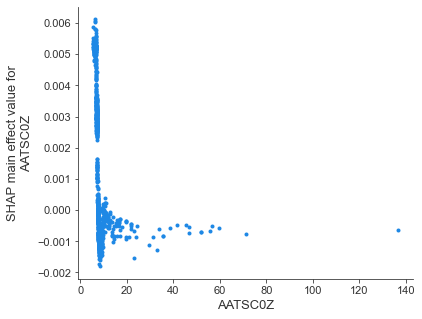

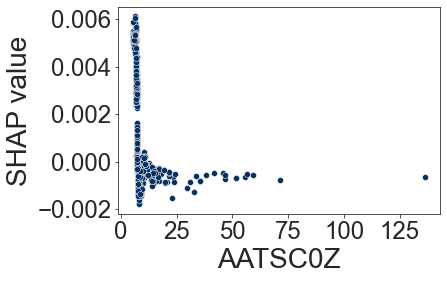

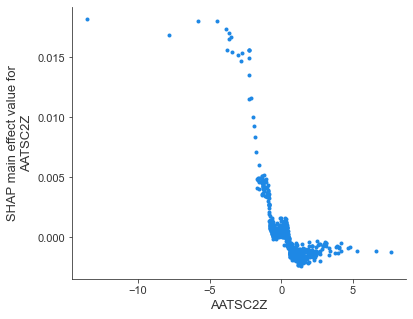

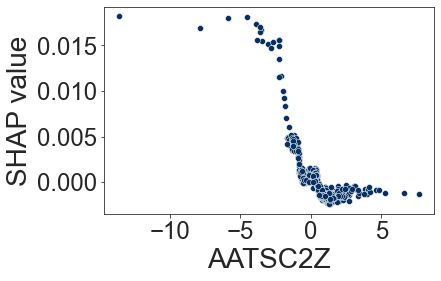

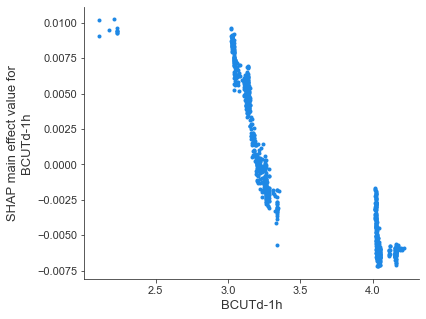

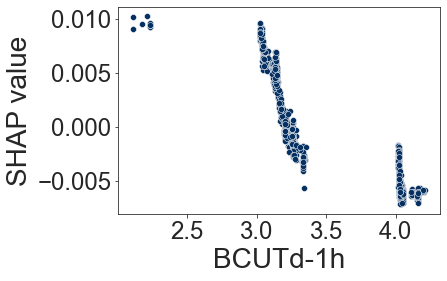

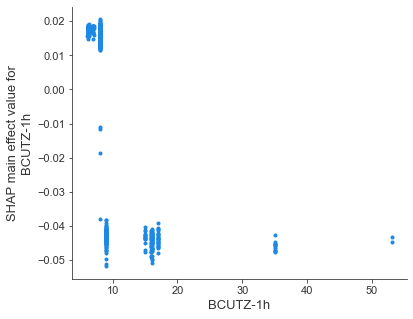

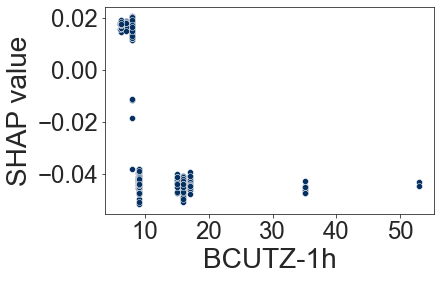

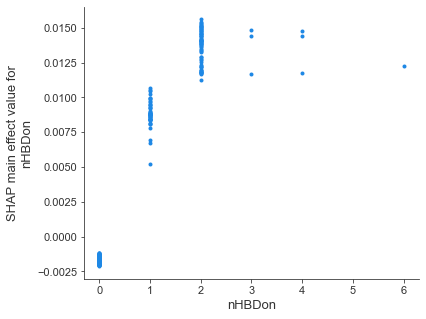

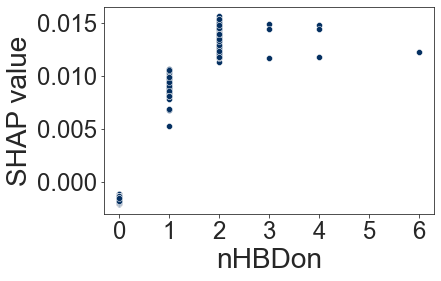

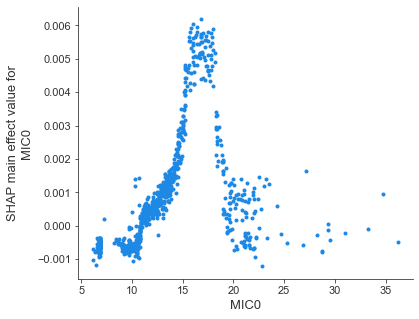

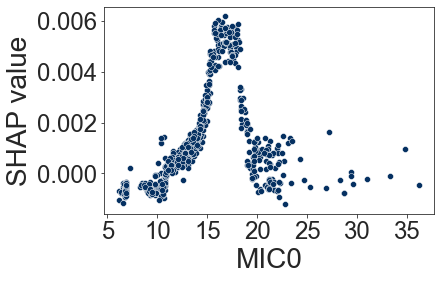

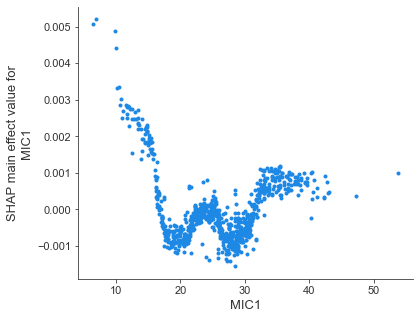

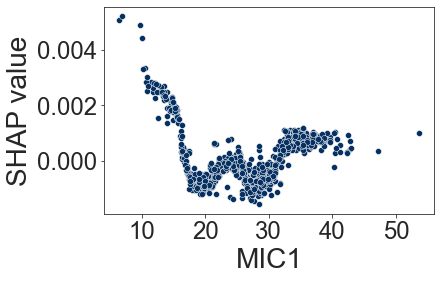

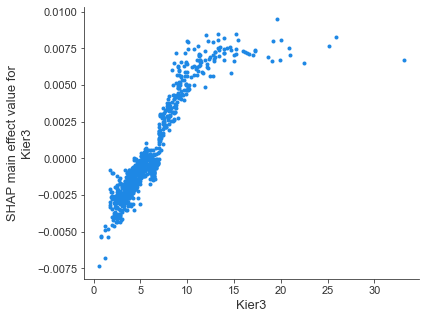

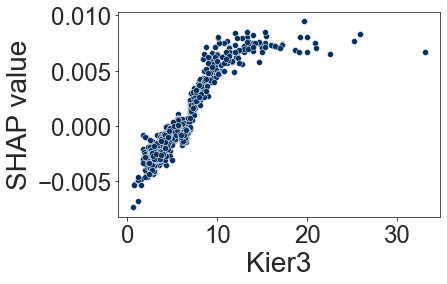

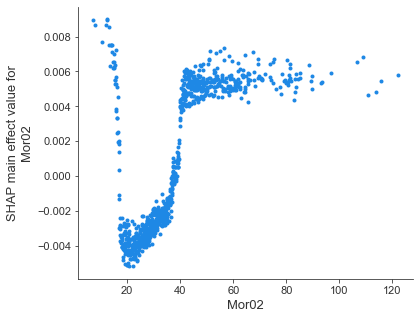

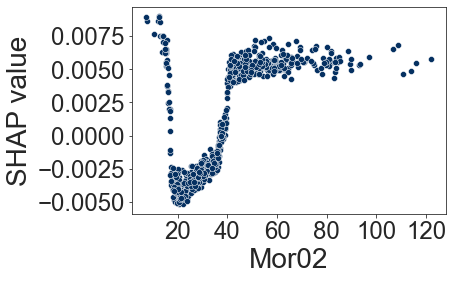

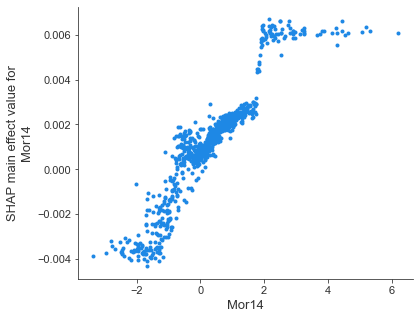

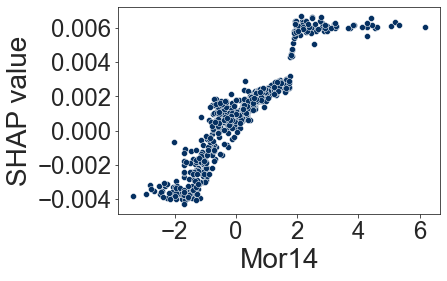

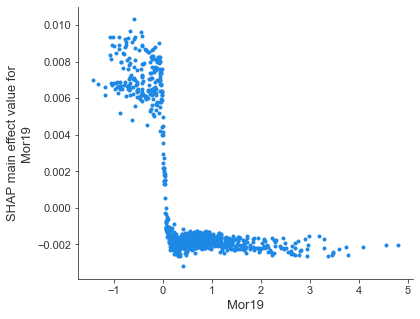

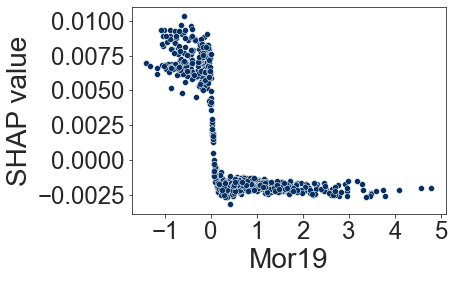

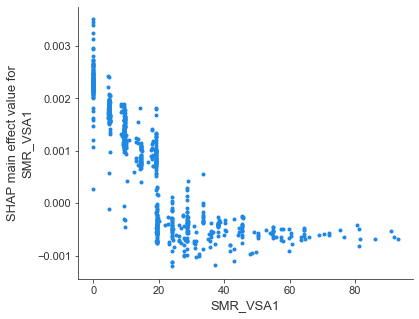

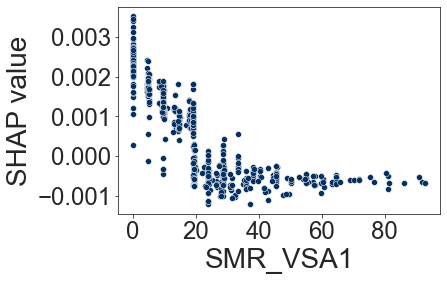

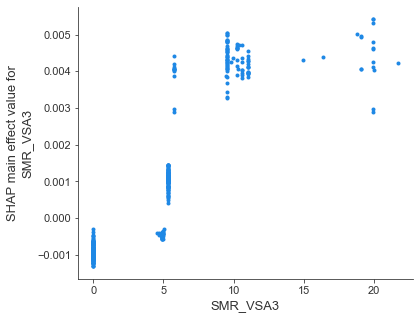

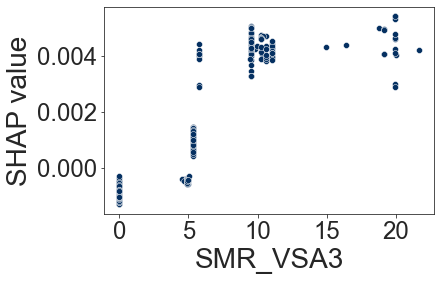

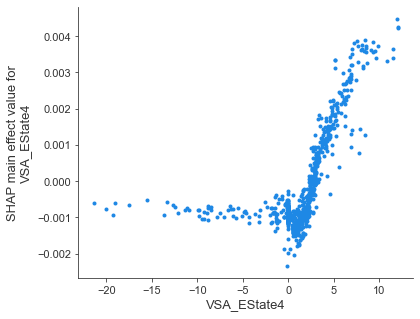

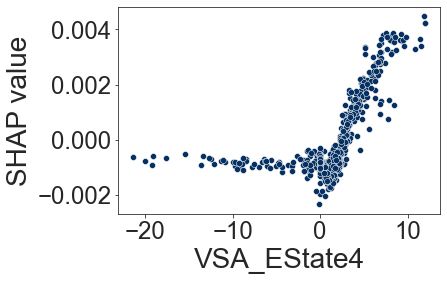

In [30]:
shap_interaction_values = explainer.shap_interaction_values(X_FEATURE)
for fea in feature_name_list:
    fig,ax = plt.subplots()
    shap.dependence_plot(
        (fea, fea),
        shap_interaction_values,X_selecttrain,
        display_features=X_selecttrain,
        cmap='copper', show=False, ax=ax
    )
    plt.show()
    xdata=np.array(ax.collections[0].get_offsets())
    ydata=np.ravel(xdata[:,1])
    xdata=np.ravel(xdata[:,0])
    xlabel=ax.collections[0].get_label()

    import seaborn as sns
    plt.figure(figsize=(6,4))
    colorlist=['#053061']
    sns.set_style('ticks')
    sns.set_palette('copper')
    ax=sns.scatterplot(x=xdata,
                y=ydata,
                #height=plt.rcParams['figure.figsize'][0],
                #aspect=plt.rcParams['figure.figsize'][1]/plt.rcParams['figure.figsize'][0])#,
                color=colorlist)#np.array(sn.color_palette())[4,:])
                #palette='copper')

    #{'font.size': 10, 'figure.figsize': (6.0, 4.0), 'figure.facecolor': 'white', 'savefig.dpi': 72, 'figure.subplot.bottom': 0.125, 'figure.edgecolor': 'white'}
    ax.set_xlabel(fea,fontsize=28)
    ax.set_ylabel('SHAP value',fontsize=28)
    #handles, labels = ax.get_legend_handles_labels()
    #plt.legend(handles[:1], labels[:1], loc='upper right', frameon=True, markerscale=0.5, borderpad=0.2,
    #           labelspacing=0.2, borderaxespad=0.3, handlelength=1)

    plt.tight_layout()
    plt.yticks(fontproperties = 'Arial', size = 24)
    plt.xticks(fontproperties = 'Arial', size = 24)
    plt.show()

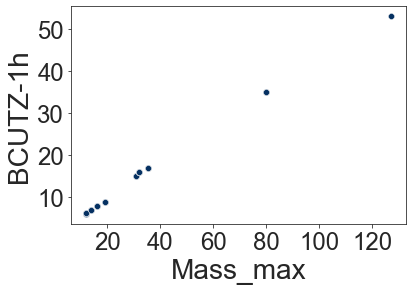

In [37]:
#The relationship between BCUTZ-1h and Mass_max
BCU=train_df["BCUTZ-1h"]
Mass_max=train_df["Mass_max"]
plt.figure(figsize=(6,4))
colorlist=['#053061']
sns.set_style('ticks')
sns.set_palette('copper')
ax=sns.scatterplot(x=Mass_max,
            y=BCU,
            color=colorlist)
ax.set_xlabel("Mass_max",fontsize=28)
ax.set_ylabel('BCUTZ-1h',fontsize=28)
plt.yticks(fontproperties = 'Arial', size = 24)
plt.xticks(fontproperties = 'Arial', size = 24)
plt.show()

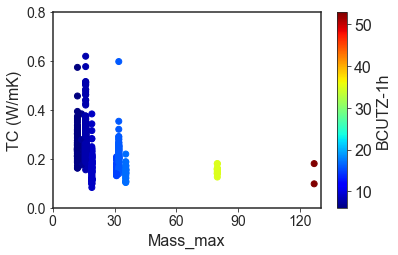

In [45]:
df=train_df[['monomer_ID','Mass_max','BCUTZ-1h','TC']]
fig,ax = plt.subplots(figsize=(6,3.6))
plt.rc('font', family='Arial')
plt.rcParams.update({'font.size':16})
ax_plot = ax.scatter( x= 'Mass_max', y= 'TC',alpha=1,
c= 'BCUTZ-1h', cmap=plt.get_cmap("jet"),data=df)
ax.spines['bottom'].set_linewidth('1.5')
ax.spines['top'].set_linewidth('1.5')
ax.spines['right'].set_linewidth('1.5')
ax.spines['left'].set_linewidth('1.5')
ax.set_xlabel('Mass_max', fontsize=16) 
ax.set_ylabel('TC (W/mK)', fontsize=16) 
plt.yticks(fontsize=14)
plt.xlim((0, 130))
plt.ylim((0, 0.8))
my_x_ticks = np.arange(0,131,30)
plt.xticks(my_x_ticks,size=14)
fig.colorbar(ax_plot,ax=ax,label='BCUTZ-1h')
plt.show()